In [91]:
import os
import sys
import glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xray
import random
import itertools
import urllib
import json
import importlib as imp

from IPython import display

sys.path.append('/nuwa_cluster/home/jackyu/climatools/')
import climatools.dates as climadates
import climatools.viz as climaviz
import climatools.misc as climamisc
import climatools.muths as climaths
import climatools.units as climaunits
import climatools.geocoords as climageocoords

#from IPython.lib.deepreload import reload as dreload
imp.reload(climadates)
imp.reload(climaviz)
imp.reload(climamisc)
imp.reload(climaths)
imp.reload(climaunits)

matplotlib.rcParams.update({'font.size': 13, 
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

# TWPICE

2 cases considered here are:

* all RRTMG --- RRTMG used for both longwave and shortwave, output sent to CAM
* rad CLIRAD --- CLIRAD used for both longwave and shortwave, output not sent to CAM

RRTMG and CLIRAD are used in each time step to compute radiation.  Both take in the same input from CAM.  Only RRTMG's output at each time step is sent back to CAM.


In [92]:


def swflx_sorad():
    print('Shortwave fluxes at the end of subroutine sorad()')
    df = pd.read_csv('../examples/TWPICE/cam5_noavg_LW_rrtmgclirad_SW_rrtmgclirad/sw_flux.dat',
                    header = 0, index_col = [0, 1, 2, 3,], sep = r'\s+')

    klev_tom, klev_bom = 2, 32
    
    print()
    print()
    print('DataFrame head')
    print(df.head())
    
    df.index = df.index.droplevel(['iNDay', 'iIdxDay'])
    
    # calculate w_swdflx - w_swuflx
    df.loc[:, 'w_swdflx - w_swuflx'] = df.loc[:, 'w_swdflx'] - df.loc[:, 'w_swuflx']
    
    # get TOM net downward flux
    net_swdflx_TOM = df.loc[(slice(None), klev_tom), ['w_swnflx', 'w_swdflx - w_swuflx']]
    
    net_swdflx_TOM.index = net_swdflx_TOM.index.droplevel('klev')
    
    net_swdflx_TOM = net_swdflx_TOM.\
    reindex(range(net_swdflx_TOM.index.values[-1])).fillna(0.)
    
    print(net_swdflx_TOM.shape)
    
    print()
    print()
    #print('--------------------------------------------------')
    print('Compare w_swnflx with (w_swdflx - w_swuflx) at TOM')
    #print('--------------------------------------------------')
    fig, ax = plt.subplots(ncols=1, nrows=1,
                      figsize = (18, 10))    
    
    ax.plot(pd.rolling_mean(net_swdflx_TOM['w_swnflx'], 9), color = 'm', label = 'w_swnflx')
    net_swdflx_TOM['w_swdflx - w_swuflx'][:: 9].plot(ax = ax, color = 'b', linestyle = '--',
                                                    label = 'w_swdflx - w_swuflx')
    #ax.plot(net_swdflx_TOM['w_swdflx - w_swuflx'], marker = None, linestyle = '-', 
     #       label = 'w_swdflx - w_swuflx', color = 'r')
    
    ax.set_title('Net downward flux at top of model')
    
    ax.set_ylabel('Flux [$W m^{-2}$]')
    ax.yaxis.grid(b = True, which = 'major')
    
    ax.set_xlabel('nstep')
    ax.xaxis.grid(b = True, which = 'major')
    
    ax.legend()
    
    return net_swdflx_TOM

SHORTWAVE FLUXES AT TOP OF MODEL

FSNT
            all RRTMG  rad CLIRAD
time                             
0.000000   875.428223  764.723877
0.013889  1017.817078  905.284851
0.027778   723.537476  720.251282
0.041667   908.072998  688.099121
0.055556   880.229736  701.326599

FS_top (from FUS and FDS)
            all RRTMG                            rad CLIRAD              \
                  FDS         FUS       net FS          FDS         FUS   
time                                                                      
0.000000  1381.541870  506.113647   875.428223  1382.288940  617.565002   
0.013889  1384.662231  366.845215  1017.817017  1385.415039  480.130157   
0.027778  1378.112183  654.574768   723.537415  1378.845459  658.594116   
0.041667  1361.777100  453.704102   908.072998  1362.536133  674.437012   
0.055556  1335.889648  455.659973   880.229675  1336.639648  635.313049   
0.069444  1300.611206  436.934570   863.676636  1301.369019  633.525574   
0.083333  1256.242310

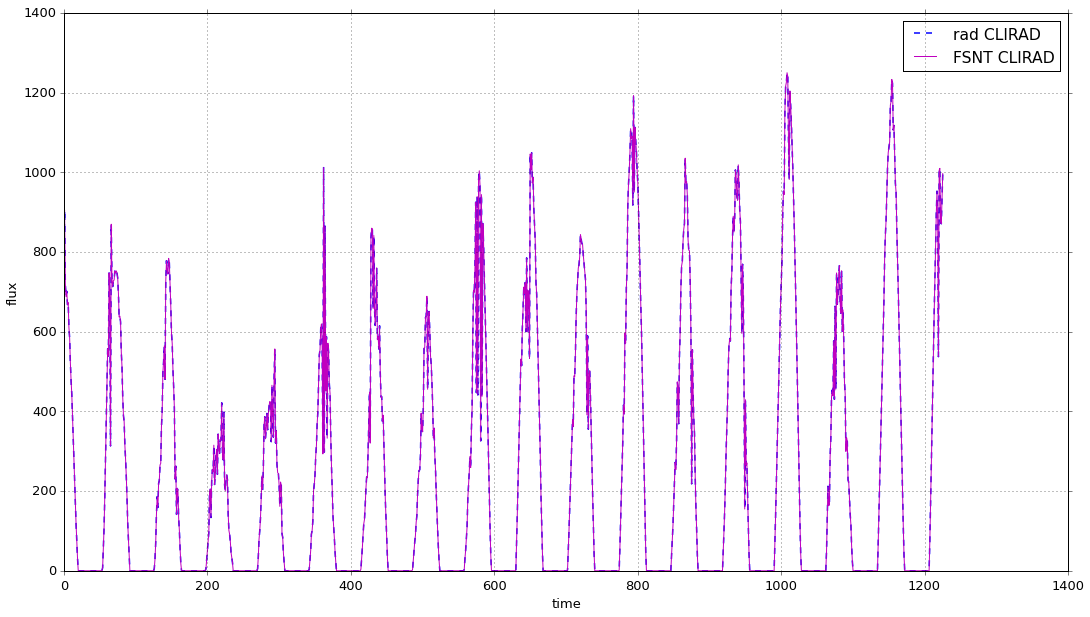

In [117]:


def glance_FDS():
    print('Shortwave fluxes at top of model'.upper())
    with xray.open_dataset('../examples/TWPICE/cam5_noavg_LW_rrtmgclirad_SW_rrtmgclirad/camrun.cam.h0.2006-01-17-10800.nc',
                          decode_times = False) as ds0:
        ds = ds0.copy(deep = True)
        
    which_slice = dict(lon = 0, lat = 0, ilev = 0)
    
    # RRTMG
    FDS_rrtmg = 1e3 * ds['FDS'][which_slice].to_pandas()
    FUS_rrtmg = 1e3 * ds['FUS'][which_slice].to_pandas()
    FS_rrtmg = pd.concat([FDS_rrtmg, FUS_rrtmg], axis = 1, keys = ['FDS', 'FUS'])
    FS_rrtmg.loc[:, 'net FS'] = FS_rrtmg.loc[:, 'FDS'] - FS_rrtmg.loc[:, 'FUS']
    
    FSNT_rrtmg = ds['FSNT'][dict(lon = 0, lat = 0)].to_pandas()
    
    # CLIRAD
    FDS_clirad = 1e3 * ds['FDS_clirad'][which_slice].to_pandas()
    FUS_clirad = 1e3 * ds['FUS_clirad'][which_slice].to_pandas()  
    FS_clirad = pd.concat([FDS_clirad, FUS_clirad], axis = 1, keys = ['FDS', 'FUS'])
    FS_clirad.loc[:, 'net FS'] = FS_clirad.loc[:, 'FDS'] - FS_clirad.loc[:, 'FUS']
    
    FSNT_clirad = ds['FSNT_clirad'][dict(lon = 0, lat = 0)].to_pandas()

    #BOTH
    FS_top = pd.concat([FS_rrtmg, FS_clirad], axis = 1, keys = ['all RRTMG', 'rad CLIRAD'])
    FSNT = pd.concat([FSNT_rrtmg, FSNT_clirad], axis = 1, keys = ['all RRTMG', 'rad CLIRAD'])
    
    print()
    print('==================================')
    print('FSNT')
    print('==================================')
    print(FSNT.head())

    print()
    print('==================================')
    print('FS_top (from FUS and FDS)')
    print('==================================')
    print(FS_top.iloc[ : 20, :])

    print()
    print('==================================')
    print('plot net flux at TOA')
    print('==================================')
    fig, axes = plt.subplots(figsize = (18, 10), dpi = 300,
                            nrows = 1, ncols = 1)
#    axes.plot(FS_top[('all RRTMG', 'net FS')], 
#              linestyle = '--', color = 'g', label = 'all RRTMG', linewidth = 1.5)

#    axes.plot(FSNT['all RRTMG'], marker = '*', linestyle = 'None', color = 'g', label = 'FSNT RRTMG')

    axes.plot(FS_top[('rad CLIRAD', 'net FS')], 
              linestyle = '--', color = 'b', label = 'rad CLIRAD', linewidth = 1.5)
    
    axes.plot(FSNT['rad CLIRAD'], marker = 'None', linestyle = '-', color = 'm', label = 'FSNT CLIRAD')
    
    axes.set_xlabel('time')
    axes.xaxis.grid(b = True, which = 'major')
    
    axes.set_ylabel('flux')
    axes.yaxis.grid(b = True, which = 'major')  
    
    axes.legend()
    

    
#    diff_colour = (0.929, 0.329, 0.972)
#    ax2 = axes.twinx()
#    ax2.plot(FS_top[('rad CLIRAD', 'net FS')] - FS_top[('all RRTMG', 'net FS')], 
#              linestyle = '-', color = diff_colour, linewidth = 1.5,
#             label = 'rad CLIRAD - all RRTMG')
    
#    [ticklabel.set_color(diff_colour) for ticklabel in ax2.yaxis.get_ticklabels()]
    
#    ax2.legend()
    
    

    
    
glance_FDS()


In [94]:
iopname = 'twpice_LWrrtmgclirad_SWrrtmgclirad'

def case_names():
    return ['all RRTMG', 'rad CLIRAD']

# Each case here refers to a model, or a model configuration, and is assigned the path to its output data.
def get_cases():
    '''
    Returns a dictionary where the keys are cases, such
    as a name for a SCAM run, and the values are the datasets (xray)
    for the cases
    '''
    ds = xray.open_dataset('../examples/TWPICE/cam5_noavg_LW_rrtmgclirad_SW_rrtmgclirad/camrun.cam.h0.2006-01-17-10800.nc',
                          decode_times = False)
    clirad_names = [k for k in list(ds) if '_clirad' in k]
    rrtmg_names = [name.split('_')[0] for name in clirad_names]
    common_names = [k for k in list(ds) 
                    if k not in (clirad_names + rrtmg_names)]
    
    ds_clirad = xray.Dataset()
    ds_clirad.update(ds[common_names].copy(deep = True), inplace = True)
    ds_clirad.update(ds[clirad_names].copy(deep = True), inplace = True)
    ds_clirad.rename(dict(zip(clirad_names, rrtmg_names)), inplace = True)
    
    ds_rrtmg = xray.Dataset()
    ds_rrtmg.update(ds[common_names].copy(deep = True), inplace = True)
    ds_rrtmg.update(ds[rrtmg_names].copy(deep = True), inplace = True)     
    
       
    return dict(zip(case_names(), [ds_rrtmg, ds_clirad]))





def compute_net_solar_fluxes(datasets):
    '''
    Compute net solar fluxes
    '''
    for casename, ds in datasets.items():
        ds['net_FS'] = ds['FDS'] - ds['FUS']
        ds['net_FS'].attrs['units'] = ds['FDS'].attrs['units']
        ds['net_FS'].attrs['long_name'] = 'net solar flux'
        ds['net_FS'].attrs['case_name'] = casename
        
        ds['net_FSC'] = ds['FDSC'] - ds['FUSC']
        ds['net_FSC'].attrs['units'] = ds['FDSC'].attrs['units']
        ds['net_FSC'].attrs['long_name'] = 'net solar flux (clear-sky)'
        ds['net_FSC'].attrs['case_name'] = casename
    return datasets




def linestyles_by_case():
    return dict(zip(case_names(), 
                    [{'colour': 'g', 'linestyle': '--'},
                     {'colour': 'b', 'linestyle': '--'}]))

In [95]:
def get_cases_difference():
    return [('rad CLIRAD', 'all RRTMG'),]

In [96]:
############### Coordinate conversion functions ################
################################################################
# *lev* is converted from hybrid levels to mbar.    
# *time* is converted from days since start to datetime.datetime objects


def convert_pressure_time_units(cases):
    '''
    Convert pressure and time units to mbar and datetime objects.
    This assumes all datasets have the same pressure and time
    coordinates.  This conversion is done early using fields such as
    hyam, which will not be needed later.
    '''
    ds = cases[random.choice(list(cases.keys()))]
    lev = climaunits.hybrid2mbar(ds, level_type = 'lev')
    ilev = climaunits.hybrid2mbar(ds, level_type = 'ilev')
    datetimes = climadates.time2datetimes(ds)
    datetimes = [climadates.\
                 UTCtime_to_localtime(datetime, 
                                      lon = climageocoords.\
                                      positivise_longitude(ds['lon'].values[0])) \
                 for datetime in datetimes]
    return ilev, lev, datetimes

In [97]:
cases = get_cases()
cases = compute_net_solar_fluxes(cases)
ilev, lev, datetimes = convert_pressure_time_units(cases)

In [98]:
################## Variables of dimensions (time, lev, lon, lat) ########################
################################################################################

In [99]:
### for pre-processing



def get_d3interests():
    '''List all interested fields here.  
    These have to be of dimensions (time, lev, lon, lat)'''
    d3interests = ['CLOUD', 'QRL', 'QRS', 'Q',
                   'CLDICE', 'CLDLIQ', 
                   'AQSNOW', 'AREI', 'AREL',
                  'AWNC', 'AWNI', 
                   'DCQ', 'DTCOND', 
                   'ICIMR', 'ICWMR', 
                   'NUMLIQ', 'NUMICE', 'T', 'RELHUM',
                  'FUL', 'FDL', 'FULC', 'FDLC', 'net_FS', 'net_FSC',
                  'FUS', 'FDS', 'FUSC', 'FDSC',
                  'TOT_CLD_VISTAU']
    return sorted(d3interests)


def gather_interests_from_cases(cases, interests):
    '''
    Creates a dictionary with keys being the cases.
    For each case is an Xray Dataset containing the interested fields
    '''
    datasets = {} 

    for case, ds in cases.items():
        datasets[case] = ds[interests].copy(deep = True)
        datasets[case].attrs['case_name'] = case
    return datasets


def convert_units(datasets, ilev, lev, datetimes):
    '''
    Convert units for certain fields for all cases in DATASETS.
    INPUT:
    ilev --- level(interface) pressure in mbar
    lev  --- layer(level) pressure in mbar
    datetimes --- time in pandas DatetimeIndex objects
    '''
    for name, ds in datasets.items():
        ds.coords['ilev'] = ('ilev', ilev, {'units': 'mbar'})
        ds.coords['lev'] = ('lev', lev, {'units': 'mbar'})
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime'})
        
        for k in ['TOT_CLD_VISTAU',]:
            if k in ds:
                pass #ds[k].values[ds[k].isnull().values] = - 0.
        
        for k in ['FUS', 'FDS', 'net_FS', 'net_FSC']:
            if k in ds:
                ds[k] *= 1e3
    
        for k in ['QRL', 'QRS', 'DTCOND']:
            if k in ds:
                ds[k] *= 86400
                ds[k].attrs['units'] = 'K/day'
        
        for k in ['Q', ]:
            if k in ds:
                ds[k] *= 1e3
                ds[k].attrs['units'] = 'g/kg'
        
        for k in ['CLDICE', 'CLDLIQ', 'AQSNOW']:
            if k in ds:
                ds[k] *= 1e6
                ds[k].attrs['units'] = 'mg/kg'
                
    return datasets





def take_difference_between_cases(datasets):
    '''
    Take the difference between all cases for every field
    and return in a similar dictionary
    '''
    diff_strs = get_cases_difference()
    
    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}


def passon_attrs_casename(datasets, diff_datasets):
    '''
    Create an attribute for each case.
    Copy over attributes to the differences.
    This is not nice, might be good to get rid of 
    the dependency on this.
    '''
    interests = get_d3interests() 
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(
                datasets[random.choice(list(datasets.keys()))][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets


def prep_data(cases, ilev, lev, datetimes):
    '''
    Preprocess data for plotting. 
    pressure and datetimes need to be provided for unit conversion.
    INPUT:
    ilev --- level(interface) pressure [mbar]
    lev --- layer(level) pressure [mbar]
    datetimes --- time in pandas DatetimeIndex objects    
    '''
    interests = get_d3interests()
    datasets = gather_interests_from_cases(cases, interests)
    datasets = convert_units(datasets, ilev, lev, datetimes)
    diff_datasets = take_difference_between_cases(datasets)
    datasets, diff_datasets = passon_attrs_casename(datasets, diff_datasets)
    return datasets, diff_datasets


In [100]:
def interests_using_bwr_cmap():
    return ['QRL', 'QRS',
           'DTCOND', 'DCQ']



# for writing plotted figures to disk
def writefig_contourfs(d3sets, diff_d3sets, 
                       interests, sitename,
                      fmt = 'png'):
    '''
    For each interest, produce one figure containing contour
    plots for all cases, another figure containing contour 
    Hackish colormap selection here, basically look up a dictionary.
    '''

    for interest in interests:
        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)

        if interest in interests_using_bwr_cmap():
            cmap_name = 'bwr'
        else:
            cmap_name = 'PuBuGn'
            
        fig = climaviz.contourf_interest_for_all_cases(d3sets, interest,
                                           cmap = plt.get_cmap(cmap_name))
        fig.savefig(dirname + '/contourf_{}.{}'.format(interest, fmt))
        plt.close()
        
        fig = climaviz.contourf_interest_for_all_cases(diff_d3sets, interest,
                                           cmap = plt.get_cmap('bwr'))
        fig.savefig(dirname + '/contourf_{}_diff.{}'.format(interest, fmt))
        plt.close()
        

        
def writefig_timeaveraged_VSplots(d3sets, diff_d3sets,
                                 interests, sitename,
                                 fmt = 'png'):
    for interest in interests:        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
            
        fig = climaviz.plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, 
                               interest = interest, xscale = 'linear',
                               bot_xlabels_rotate = 10., 
                               top_xlabels_rotate = 20.,
                               linestyles = linestyles_by_case())
        fig.savefig(dirname + '/plot_{}_timeaverage.{}'.format(interest, fmt))
        plt.close()

In [101]:
def write_d3variable_html_page(iopname = 'mpace', interest = 'CLOUD',):
    figdir = 'figs_' + iopname
    with open(os.path.join(figdir, iopname + '_' + interest + '.html'), 
              mode = 'w', encoding = 'utf-8') as f:
        f.write('''
                <img src="contourf_{interest}.png" height="450">
                <img src="contourf_{interest}_diff.png" height="450">
                <br>
                <img src="plot_{interest}_timeaverage.png" height="500">
        '''.format(figdir = figdir, interest = interest))

        
def write_d3variable_links_html(iopname = 'mpace', interests = ['T']):
    hyperlinks = ['<a href="figs_{iopname}/{iopname}_{interest}.html">{interest}: {longname}</a>'\
                 .format(iopname = iopname, 
                 interest = interest, 
                 longname = d3sets[random.choice(list(d3sets.keys()))][interest].attrs['long_name']) \
                 for interest in interests]
    return '<br>'.join(hyperlinks)
    

In [102]:
# prepare data and differences
d3sets, diff_d3sets = prep_data(cases, ilev, lev, datetimes) 

In [103]:
# plot and write figures to disk
interests = get_d3interests() 

writefig_contourfs(d3sets, diff_d3sets, 
                   interests, sitename = iopname,
                  fmt = 'png')

writefig_timeaveraged_VSplots(d3sets, diff_d3sets,
                              interests, iopname,
                              fmt = 'png')
# generate HTML page for each interest
for interest in get_d3interests():
    write_d3variable_html_page(iopname = iopname, interest = interest)


In [104]:
############### Variables of dimensions (lon, lat, time) ##########################
###################################################################################

In [105]:
def get_d2interests():
    interests = ['FSNT', 'FSNS', 'FLNT', 'FLNS',
                 'CLDLOW', 'CLDMED', 'CLDHGH', 'CLDTOT',
                 'TS', 'TREFHT', 'TROP_T', 'TROP_Z', 'TMQ', 'TGCLDIWP', 'TGCLDLWP', 
                 'PRECT', 'PRECL', 'PRECC',
                 'LHFLX', 'SHFLX',
                'SOLIN']
    return interests

In [106]:
def prep_data():

    interests = get_d2interests()

    datasets = {}
    
    for casename, ds in cases.items():
        datasets[casename] = ds[interests].copy(deep = True)
        datasets[casename].attrs['case_name'] = casename
        
    for casename, ds in datasets.items():
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime',
                                                'long_name': 'time'})
        
        for k in ['PRECC', 'PRECL', 'PRECT']:
            if k in ds:
                ds[k] *= 1e3 * 86400
                ds[k].attrs['units'] = 'mm/day'
        
    return datasets

d2sets = prep_data()

In [107]:
#### Compute difference between all cases for all interested variables
def prep_differences(datasets):
    diff_strs = get_cases_difference()

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}    

diff_d2sets = prep_differences(d2sets)

In [108]:
#### Change/correct some of the attributes
## Some of this is needed for labelling plots easily

def prep_attributes(datasets, diff_datasets):
    
    interests = get_d2interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(
                datasets[random.choice(list(datasets.keys()))][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets

d2sets, diff_d2sets = prep_attributes(d2sets, diff_d2sets)

In [109]:
# for writing figures to disk
def writefig_plotVS_timeseries(dsets, diff_dsets, interests,
                              sitename, fmt = 'png'):
    for interest in interests:
        fig = climaviz.plotVS_interest_for_all_cases(dsets, diff_dsets, interest = interest,
                                                    linestyles = linestyles_by_case())
        
        dirname = 'figs_{}'.format(sitename)
        if dirname not in glob.glob(dirname):
            os.mkdir(dirname)
            
        fig.savefig(dirname + '/plotVSts_{}.'.format(interest) + fmt)
        plt.close()

def write_d2variable_html_page(iopname = 'mpace', interest = 'FLNS'):
    figdir = 'figs_{iopname}'.format(iopname = iopname)
    with open(os.path.join(figdir, '{iopname}_{interest}.html'\
                           .format(iopname = iopname,
                                   interest = interest)),
             mode = 'w', encoding = 'utf-8') as f:
        f.write('''
        <img src="plotVSts_{interest}.png" width=700>
        '''.format(interest = interest))
        
def write_d2variables_html(iopname = 'mpace', interests = ['FLNS']):
    hyperlinks = ['<a href="figs_{iopname}/{iopname}_{interest}.html">{interest}: {longname}</a>'\
                 .format(iopname = iopname, interest = interest,
                        longname = d2sets[random.choice(list(d2sets.keys()))]\
                         [interest].attrs['long_name'])\
                 for interest in interests]
    return '<br>'.join(hyperlinks)


In [110]:
# plot and write figures to disk

writefig_plotVS_timeseries(d2sets, diff_d2sets, get_d2interests(),
                          iopname, fmt = 'png')  

# generate HTML page for each interest
for interest in get_d2interests():
    write_d2variable_html_page(iopname = iopname, interest = interest)


# Variables of dimensions (time, ilev, lon, lat)

In [111]:
display.HTML(write_d3variable_links_html(iopname = iopname, interests = get_d3interests()))

# Variables of dimensions (lon, lat, time)

In [112]:
display.HTML(write_d2variables_html(iopname = iopname, interests = get_d2interests()))

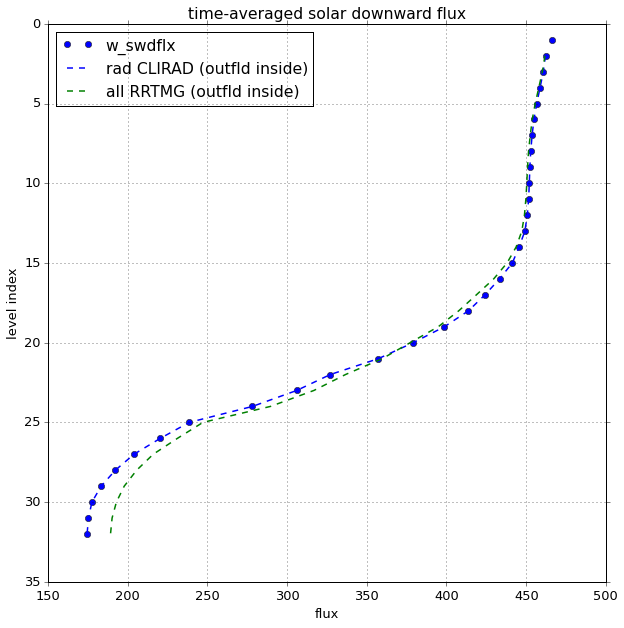

In [114]:
def sorad_direct_FDS_vs_camhist_FDS(d3sets):
    #######################################################
    # get w_swdflx (directly written out from CLIRAD sorad)
    fpath = '../examples/TWPICE/cam5_noavg_LW_rrtmgclirad_SW_rrtmgclirad/sw_flux.dat'
    df = pd.read_csv(fpath, sep = r'\s+', index_col = [0, 1, 2, 3], header = 0)

    klev_tom, klev_bom = 2, 32
    
    df.index = df.index.droplevel(['iNDay', 'iIdxDay'])

    df = df['w_swdflx'].unstack(0)
    
    # insert nighttime values (all equal to zero)
    df = df.reindex(columns = range(df.columns.values[-1]))
    df.fillna(0., inplace = True)
    
    # average over time
    df = df.mean(axis = 1)
    #########################################################
    # get FDS from CAM history (outfld outside)
    
    df_radCLIRAD = d3sets['rad CLIRAD']['FDS'][dict(lon = 0, lat = 0)].mean(dim = 'time')
    df_radCLIRAD.coords['level_index'] = ('ilev', range(klev_tom, klev_bom + 1))
    
    
    df_allRRTMG = d3sets['all RRTMG']['FDS'][dict(lon = 0, lat = 0)].mean(dim = 'time')
    df_allRRTMG.coords['level_index'] = ('ilev', range(klev_tom, klev_bom + 1))
   

    ################################################################
    # plot all
    
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1,
                          figsize = (10, 10))
    
    ax.plot(df.values, df.index.values, linestyle = 'None', marker = 'o',
           label = 'w_swdflx')
    
    ax.plot(df_radCLIRAD, df_radCLIRAD.coords['level_index'], 
           color = 'b', linestyle = '--', linewidth = 1.5, label = "rad CLIRAD (outfld inside)")
    
    ax.plot(df_allRRTMG, df_allRRTMG.coords['level_index'],
           color = 'g', linestyle = '--', linewidth = 1.5, label = "all RRTMG (outfld inside)")
   
    ax.set_title('time-averaged solar downward flux')

    ax.set_ylabel('level index')
    ax.invert_yaxis()
    ax.yaxis.grid(b = True, which = 'major')
    
    ax.set_xlabel('flux')
    ax.xaxis.grid(b = True, which = 'major')
    
    ax.legend(loc = 'best')
    
sorad_direct_FDS_vs_camhist_FDS(d3sets)

In [115]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')